In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [ ]:
# **Step 1: Load Dataset from Local Directory**
  # 👉 Replace this with your actual file path
df = pd.read_csv("IMDB_Dataset.csv", on_bad_lines='skip')

In [ ]:
# **Step 1: Handling Null Values**
df.dropna(inplace=True)  # Remove missing values

In [ ]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# **Step 3: Text Preprocessing (Cleaning)**
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [ ]:
df['review'] = df['review'].apply(clean_text)

In [ ]:
# **Step 4: Convert Sentiments to Binary**
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
# **Tokenization & Padding**
vocab_size = 6000  # ✅ Reduced vocab size for faster training
max_length = 150  # ✅ Reduced sequence length
embedding_dim = 64  # ✅ Smaller embedding size
batch_size = 64 # ✅ Lower batch size for memory efficiency

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

In [ ]:
# **Train-Test Split**
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment'], test_size=0.2, random_state=42)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),  # Convolutional Layer
    tf.keras.layers.GlobalMaxPooling1D(),  # Pooling Layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),  # Dropout for Regularization
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output Layer
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# **Compile Model**
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# **Train Model (Fewer Epochs)**
history = model.fit(X_train, y_train, epochs=4, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.6929 - loss: 0.5385 - val_accuracy: 0.8717 - val_loss: 0.2900
Epoch 2/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 75ms/step - accuracy: 0.9119 - loss: 0.2274 - val_accuracy: 0.8861 - val_loss: 0.2702
Epoch 3/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 47ms/step - accuracy: 0.9639 - loss: 0.1123 - val_accuracy: 0.8805 - val_loss: 0.3180
Epoch 4/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 59ms/step - accuracy: 0.9887 - loss: 0.0426 - val_accuracy: 0.8785 - val_loss: 0.3896


In [ ]:
# **Evaluate Model**
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {test_acc:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8808 - loss: 0.3764

✅ Test Accuracy: 0.88


In [ ]:
# **Predictions & Metrics**
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n✅ Performance Metrics:")
print(f"🔹 Accuracy: {accuracy * 100:.2f}%")
print(f"🔹 Precision: {precision:.2f}")
print(f"🔹 Recall: {recall:.2f}")
print(f"🔹 F1-Score: {f1:.2f}")


✅ Performance Metrics:
🔹 Accuracy: 87.85%
🔹 Precision: 0.89
🔹 Recall: 0.87
🔹 F1-Score: 0.88


In [ ]:
# **Step 14: Misclassified Samples**
misclassified_indices = np.where(y_pred != y_test.to_numpy())[0]
print(f"\n🔹 Number of Misclassified Samples: {len(misclassified_indices)}")


🔹 Number of Misclassified Samples: 1215


In [ ]:
# Get some misclassified sample indices
num_samples_to_display = 5  # Change this number if you want to see more examples
misclassified_samples = misclassified_indices[:num_samples_to_display]

print("\n🔹 Sample Misclassified Reviews:")
for idx in misclassified_samples:
    print(f"\n🔹 Review: {df.iloc[idx]['review'][:300]}...")  # Displaying first 300 characters
    print(f"   ✅ Actual Sentiment: {'Positive' if y_test.iloc[idx] == 1 else 'Negative'}")
    print(f"   ❌ Predicted Sentiment: {'Positive' if y_pred[idx] == 1 else 'Negative'}")



🔹 Sample Misclassified Reviews:

🔹 Review: this show was an amazing fresh innovative idea in the 70s when it first aired the first 7 or 8 years were brilliant but things dropped off after that by 1990 the show was not really funny anymore and its continued its decline further to the complete waste of time it is todayits truly disgraceful how...
   ✅ Actual Sentiment: Positive
   ❌ Predicted Sentiment: Negative

🔹 Review: first of all lets get a few things straight here a i am an anime fan always has been as a matter of fact i used to watch speed racer all the time in preschool b i do like several bmovies because theyre hilarious c i like the godzilla movies a lotmoving on when the movie first comes on it seems like ...
   ✅ Actual Sentiment: Positive
   ❌ Predicted Sentiment: Negative

🔹 Review: my first exposure to the templarios not a good one i was excited to find this title among the offerings from anchor bay video which has brought us other cult classics such as spider baby the p

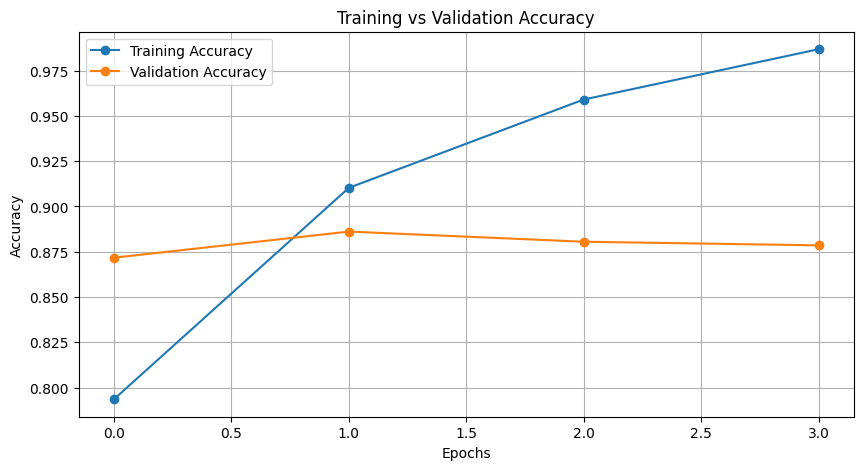

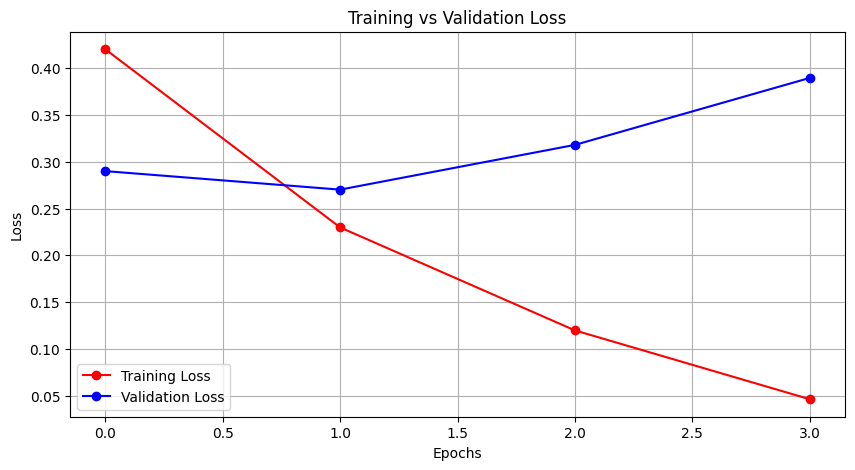

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# **Plot 1: Training vs Validation Accuracy**
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

# **Plot 2: Training vs Validation Loss**
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()




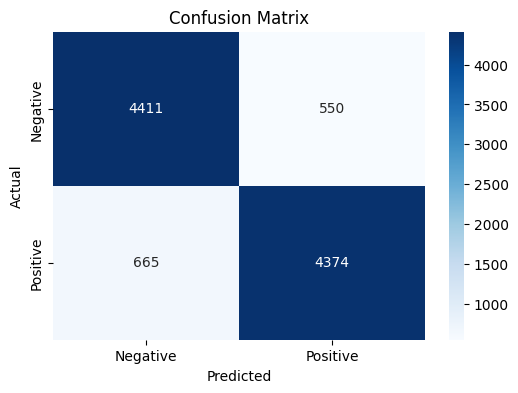

In [ ]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Import seaborn if not already imported
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Clean the user input the same way as dataset
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to predict a new review
def predict_review(review_text):
    review_text = clean_text(review_text)
    seq = tokenizer.texts_to_sequences([review_text])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    pred = model.predict(padded)[0][0]
    sentiment = "Positive" if pred >= 0.5 else "Negative"
    print(f"\n📝 Review: {review_text}")
    print(f"🔮 Predicted Sentiment: {sentiment} ({pred:.2f})")

# Example Usage
user_input = input("Enter a movie review: ")
predict_review(user_input)


Enter a movie review: This movie was absolutely fantastic! The storyline was gripping and the acting was top-notch
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

📝 Review: this movie was absolutely fantastic the storyline was gripping and the acting was topnotch
🔮 Predicted Sentiment: Positive (1.00)
